In [68]:
from CEseek_class import *
import os, pickle, logging, psutil, numpy as np, pandas as pd, multiprocessing as mp
from tqdm import tqdm
from collections import OrderedDict
import torch, glob, dask
logging.basicConfig(filename='ceseek_cicero.log', level=logging.INFO, format='%(asctime)s %(message)s', datefmt='%H:%M:%S')
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'ce_seek')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files/txt_files_for_cicero", exist_ok=True) # will make outfiles too if they don't exist
os.makedirs(f"{out_path}/scripts", exist_ok=True)

In [69]:
def create_CEseek_obj(wd, out_path):
    CEseek_obj = CEseek()
    CEseek_obj.load_sequences(f"{wd}/in_data_required/cell_ranger_output_aggr/atac_peaks.bed",
                             genome_sequence_fa="/ocean/projects/cis240075p/skeshari/utils_data/genomes/GRCh38.p14.genome.fa", 
                             fasta_input=False, out_seq_len=300)
    # Generate random control sequences in batches
    sequence_len = len(CEseek_obj.sequences)
    batch_size = int(1e5)
    random_sequences = []
    for _ in tqdm(range(0, sequence_len, batch_size), desc='Generating control sequences'):
        random_sequences.extend([get_random_seq(300) for _ in range(min(batch_size, 10 * sequence_len))])
    CEseek_obj.sequences_control = random_sequences


    save_path = os.path.join(out_path, 'out_files/CEseek_obj_pre_motif_scan.pkl')
    with open(f'{out_path}/out_files/CEseek_obj_pre_motif_scan.pkl', 'wb') as f:
        pickle.dump(CEseek_obj, f)
    return CEseek_obj

def process_batch_for_cicero_peaks_indexed(batch):
    batch_dict = {}
    for _, row in batch.iterrows():
        key = sorted((row['Peak1_idx'], row['Peak2_idx']))
        if key[0] not in batch_dict:
            batch_dict[key[0]] = {}
        batch_dict[key[0]][key[1]] = row['coaccess']
    return batch_dict

def create_cicero_peaks_indexed(wd, out_path):
    # Build Cicero connections matrix
    cicero_conns = pd.read_csv(f"{wd}/out_data/cicero_output/cicero_connections.csv", header=0, index_col=0).dropna()
    cicero_conns = cicero_conns[cicero_conns['coaccess'] != 0].reset_index(drop=True)
    cicero_peaks_set = pd.concat([cicero_conns['Peak1'], cicero_conns['Peak2']]).unique() # Precompute indices for peaks
    cicero_peaks_index = {peak: idx for idx, peak in enumerate(sorted(cicero_peaks_set))}

    with open(f"{out_path}/out_files/cicero_peaks_indexed.pkl", 'wb') as f:
        pickle.dump(cicero_peaks_index, f)
    
    cicero_conns['Peak1_idx'] = cicero_conns['Peak1'].map(cicero_peaks_index)
    cicero_conns['Peak2_idx'] = cicero_conns['Peak2'].map(cicero_peaks_index)
    num_peaks = len(cicero_peaks_index)

    # Split into batches and save in compressed format
    index_value_dict = {}
    num_chunks = mp.cpu_count()
    chunks = np.array_split(cicero_conns, num_chunks)

    with mp.Pool(num_chunks) as pool:
        results = list(tqdm(pool.imap(process_batch_for_cicero_peaks_indexed, chunks), total=num_chunks, desc='Processing Cicero connections batches'))
    
    for result in results:
        index_value_dict.update(result)

    with open(f"{out_path}/out_files/matrix_index_value.pkl", 'wb') as f:
        pickle.dump(index_value_dict, f)
    return cicero_peaks_index, index_value_dict


In [4]:
run_CEseek = True
if run_CEseek:
    if not os.path.exists(f"{out_path}/out_files/CEseek_obj_pre_motif_scan.pkl"):
        CEseek_obj = create_CEseek_obj(wd, out_path)
    else:
        print(f"Loading CEseek object {out_path}/out_files/CEseek_obj_pre_motif_scan.pkl. Delete it if you want to re-create it.")
        with open(f"{out_path}/out_files/CEseek_obj_pre_motif_scan.pkl", 'rb') as f:
            CEseek_obj = pickle.load(f)

if (not os.path.exists(f"{out_path}/out_files/cicero_peaks_indexed.pkl")) or (not os.path.exists(f"{out_path}/out_files/matrix_index_value.pkl")):
    cicero_peaks_index, index_value_dict = create_cicero_peaks_indexed(wd, out_path)
else:
    print(f"Loading cicero peaks indexed {out_path}/out_files/cicero_peaks_indexed.pkl. Delete it if you want to re-create it.")
    with open(f"{out_path}/out_files/cicero_peaks_indexed.pkl", 'rb') as f:
        cicero_peaks_index = pickle.load(f)
    print(f"Loading cicero peaks indexed {out_path}/out_files/matrix_index_value.pkl. Delete it if you want to re-create it.")
    with open(f"{out_path}/out_files/matrix_index_value.pkl", 'rb') as f:
        index_value_dict = pickle.load(f)

Loading CEseek object /ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/ce_seek/out_files/CEseek_obj_pre_motif_scan.pkl. Delete it if you want to re-create it.
Loading cicero peaks indexed /ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/ce_seek/out_files/cicero_peaks_indexed.pkl. Delete it if you want to re-create it.
Loading cicero peaks indexed /ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/ce_seek/out_files/matrix_index_value.pkl. Delete it if you want to re-create it.


In [72]:
from pathlib import Path
directory = Path(f"{wd}/out_data/out_other_methods/JASPAR2024_CORE_vertebrates_non-redundant_homer/")
file_names = {}
for f in directory.iterdir():
    if f.is_file():
        key = f.stem.split('.')[0].lower()
        value = f.stem.split('.', 1)[1]
        if key in file_names:
            file_names[key].append(value)
        else:
            file_names[key] = [value]


def create_concatenated_pwm(tf_of_interest, cluster_pair):
    # Write file for  CESeek and Cicero based analysis
    output_file = f"{out_path}/out_files/concatenated_pwm_{cluster_pair}.txt"
    with open(output_file, 'w') as outfile:
        for tf_id in tf_of_interest:
            for file in os.listdir(directory):
                if tf_id in file or tf_id.lower() in file.lower():
                    with open(os.path.join(directory, file), 'r') as infile:
                        outfile.write(infile.read())

    return None
comb_of_interest = set()
tf_of_interest = set()
for file in glob.glob(f"{wd}/out_data/comb_ctrl/out_files/*_double_TFs_{cluster_pair}.csv"):
    df = pd.read_csv(file)
    df['TF1_mapped'] = df['TF1'].str.split('(').str[0].str.lower().map(file_names)
    df['TF2_mapped'] = df['TF2'].str.split('(').str[0].str.lower().map(file_names)
    df = df.explode('TF1_mapped').explode('TF2_mapped')
    df['TF1'] = df['TF1'].str.split('(').str[0] + '(' + df['TF1_mapped'] + ')'
    df['TF2'] = df['TF2'].str.split('(').str[0] + '(' + df['TF2_mapped'] + ')'
    comb_of_interest.update(zip(df['TF1'], df['TF2']))
    tf_of_interest.update(df['TF1_mapped'])
    tf_of_interest.update(df['TF2_mapped'])

comb_of_interest = list(comb_of_interest)
create_concatenated_pwm(tf_of_interest, cluster_pair)

In [90]:
file_names['batf3']

['MA0835.3']

In [73]:
CEseek_obj = create_CEseek_obj(wd, out_path)

Generating control sequences: 100%|██████████| 2/2 [00:15<00:00,  7.70s/it]


In [78]:
def calculate_ceseek(preferred_motif_set_name):
    # Calculating scores for the preferred motif set
    # preferred_motif_set_name=('Nfatc1(MA0624.3)', 'JUN(MA0488.2)')
    ce_seek_score =CEseek_obj.count_CE_configuration_for_motif_pair(*preferred_motif_set_name)
    ce_seek_score_df=pd.DataFrame(ce_seek_score[list(ce_seek_score.keys())[0]]).sort_index().T

    # Calculate the p-value for the preferred motif set
    dict_temp = OrderedDict({
    preferred_motif_set_name: {(strand1, strand2): {} for strand1 in ["+", "-"] for strand2 in ["+", "-"]}
    })
    EPS = 1e-40
    for strand1 in ["+", "-"]:
        for strand2 in ["+", "-"]:
            for spacing in range(-5,10+1):
                key = (strand1, strand2)
                # p_value=CEseek_obj.motif_enrichment(*preferred_motif_set_name, strand1=strand1, strand2=strand2, spacing=spacing)
                p_value = -1
                dict_temp[preferred_motif_set_name][key][spacing] = p_value

    ce_seek_pval_df=pd.DataFrame(dict_temp[preferred_motif_set_name]).sort_index().T
    max_score = ce_seek_score_df.max().max()
    max_score_loc = ce_seek_score_df.stack().idxmax()
    max_score_pval = ce_seek_pval_df.stack().loc[max_score_loc]

    # # Finding top CE-Score satisfying the p-value threshold of 0.05 from ce_seek_pval_df, ce_seek_score_df
    # p_value_threshold = 0.05 # Define the p-value threshold
    # log_p_value_threshold = -np.log10(p_value_threshold) # Convert the p-value threshold to -log10 scale
    # filtered_pvals = ce_seek_pval_df[ce_seek_pval_df >= log_p_value_threshold] # Filter the p-values that satisfy the threshol
    # filtered_scores = ce_seek_score_df[filtered_pvals.notna()] # Find the corresponding scores for the filtered p-values
    # try: 
    #     max_score = filtered_scores.max().max() # Find the maximum score and its location
    #     max_score_loc = filtered_scores.stack().idxmax()
    # except ValueError:
    #     max_score = 0
    #     max_score_loc = 0
    print(f"Preferred motif set: {preferred_motif_set_name} completed")
    return max_score, max_score_loc, max_score_pval

def safe_calculate_ceseek(comb):
    try:
        return calculate_ceseek(comb)
    except Exception as e:
        print(f"Error processing combination {comb}: {e}")
        return None, None

In [79]:
for cluster_pair in cluster_pairs[0:1]:
    CEseek_obj.read_motif_pwm(f"{out_path}/out_files/concatenated_pwm_{cluster_pair}.txt")
    CEseek_obj.scan_motifs(num_threads=os.cpu_count())
    # Writing motif search for cicero in txt files
    for TF in tqdm(CEseek_obj.dict_motif.keys()):
        if not os.path.exists(f"{out_path}/out_files/txt_files_for_cicero/{TF}.txt"):
            CEseek_obj.extract_CE_sequences(TF, None, None, None, None, outfile=f"{out_path}/out_files/txt_files_for_cicero/{TF}.txt")
    
    # slide_enriched_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv")
    # shuffle_enriched_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/shuffled_SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv")
    # network_score_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/CO_network_score_double_TFs_{cluster_pair}.csv")
    # random_tfs = pd.read_csv(f"{wd}/out_data/comb_ctrl/out_files/random_TFs_{cluster_pair}.csv")

    # comb_of_interest = set(list(zip(slide_enriched_tfs['TF1'], slide_enriched_tfs['TF2'])) + \
    #                     list(zip(shuffle_enriched_tfs['TF1'], shuffle_enriched_tfs['TF2'])) + \
    #                     list(zip(network_score_tfs['TF1'], network_score_tfs['TF2'])) + \
    #                     list(zip(random_tfs['TF1'], random_tfs['TF2'])))

    # Curating CEseek results
    max_scores, max_score_locs = [],[]
    p_value_threshold = 0.05
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(safe_calculate_ceseek, comb_of_interest), total=len(comb_of_interest), desc='Processing combinations for CEseek'))
    max_scores, max_score_locs = zip(*results)
    CEseek_results_df = pd.DataFrame({'Combination': comb_of_interest,'Max_Score': max_scores,'Location': max_score_locs})
    CEseek_results_df.to_csv(f"{out_path}/out_files/CEseek_results.csv", index=False)

Processing combinations for CEseek:   0%|          | 0/516 [00:00<?, ?it/s]

Error processing combination ('Gfi1B(MA0483.2)', 'Rarb(MA1552.2)'): 'Rarb(MA1552.2)'
Error processing combination ('BHLHE22(MA0818.2)', 'Tcf12(MA1648.2)'): 'Tcf12(MA1648.2)'Error processing combination ('FEV(MA0156.4)', 'Pgr(MA2327.1)'): 'Pgr(MA2327.1)'Error processing combination ('Tcf12(MA1648.2)', 'PAX5(MA0014.4)'): 'Tcf12(MA1648.2)'Error processing combination ('Tcf12(MA1648.2)', 'BACH2(MA1470.2)'): 'Tcf12(MA1648.2)'



Preferred motif set: ('IRF4(MA1419.2)', 'XBP1(MA0844.2)') completedPreferred motif set: ('BACH2(MA1470.2)', 'BHLHE41(MA0636.1)') completedPreferred motif set: ('Gfi1B(MA0483.2)', 'Rarb(MA0858.1)') completedPreferred motif set: ('PBX3(MA1114.2)', 'BACH2(MA1470.2)') completedPreferred motif set: ('TGIF1(MA0796.1)', 'FOS(MA1951.2)') completed



Preferred motif set: ('Creb3l2(MA0608.1)', 'BACH2(MA1470.2)') completed
Preferred motif set: ('BACH2(MA1470.2)', 'IRF4(MA1419.2)') completed
Preferred motif set: ('TGIF1(MA0796.1)', 'XBP1(MA0844.2)') completed

Preferred motif 

Processing combinations for CEseek:   0%|          | 1/516 [00:16<2:17:38, 16.04s/it]

Preferred motif set: ('Runx1(MA0002.3)', 'TCF4(MA0830.3)') completed
Preferred motif set: ('THRB(MA1574.2)', 'BATF(MA1634.2)') completed
Preferred motif set: ('SPIB(MA0081.3)', 'TFAP2A(MA0810.2)') completed


Processing combinations for CEseek:   1%|          | 3/516 [00:16<36:20,  4.25s/it]  

Preferred motif set: ('Lhx1(MA1518.3)', 'Ptf1A(MA1620.2)') completedPreferred motif set: ('EBF1(MA0154.5)', 'REL(MA0101.1)') completed

Preferred motif set: ('GMEB2(MA0862.1)', 'BHLHE22(MA1635.2)') completed
Preferred motif set: ('SRY(MA0084.2)', 'Zfp809(MA2125.1)') completed
Preferred motif set: ('BACH2(MA1101.3)', 'BHLHE22(MA1635.2)') completed
Preferred motif set: ('Creb3l2(MA0608.1)', 'TCF4(MA0830.3)') completed
Preferred motif set: ('RFX7(MA1554.2)', 'SOX4(MA0867.3)') completed
Preferred motif set: ('ZNF677(MA2101.1)', 'Nkx2-1(MA1994.2)') completedPreferred motif set: ('THRB(MA1575.2)', 'SOX4(MA0867.3)') completed

Preferred motif set: ('Zic1::Zic2(MA1628.2)', 'POU6F1(MA1549.2)') completed
Preferred motif set: ('ZNF417(MA1727.2)', 'Nfatc1(MA0624.3)') completed
Preferred motif set: ('SPIB(MA0081.3)', 'TFAP2A(MA0003.5)') completed
Preferred motif set: ('TFAP2A(MA0872.1)', 'FOXC2(MA0846.2)') completed
Preferred motif set: ('VSX2(MA0726.2)', 'ARNT::HIF1A(MA0259.2)') completed
Preferre

Processing combinations for CEseek:  11%|█         | 57/516 [00:17<01:18,  5.84it/s]

Preferred motif set: ('SOX4(MA0867.3)', 'Runx1(MA0002.3)') completed
Preferred motif set: ('BHLHE22(MA0818.2)', 'FOS(MA0476.2)') completed
Preferred motif set: ('MEF2A(MA0052.5)', 'KLF2(MA1515.2)') completed


Processing combinations for CEseek:  14%|█▍        | 71/516 [00:18<00:57,  7.68it/s]

Preferred motif set: ('STAT1::STAT2(MA0517.2)', 'NEUROG2(MA1642.2)') completed
Preferred motif set: ('BHLHE22(MA1635.2)', 'BATF(MA1634.2)') completed
Preferred motif set: ('SP1(MA0079.5)', 'TLX2(MA1577.2)') completed
Preferred motif set: ('NFKB1(MA0105.4)', 'BCL11A(MA2324.1)') completed
Preferred motif set: ('JUNB(MA0490.3)', 'Runx1(MA0002.3)') completed
Preferred motif set: ('Tcf12(MA0521.3)', 'IKZF1(MA1508.2)') completed
Preferred motif set: ('Nfatc2(MA0152.3)', 'BATF(MA1634.2)') completed
Preferred motif set: ('EBF1(MA0154.5)', 'TCF4(MA0830.3)') completed
Preferred motif set: ('BHLHE22(MA0818.2)', 'BATF(MA1634.2)') completed
Preferred motif set: ('KLF2(MA1515.2)', 'RFX7(MA1554.2)') completed
Preferred motif set: ('EBF3(MA1637.2)', 'TFAP2C(MA0524.3)') completed
Preferred motif set: ('Zic1::Zic2(MA1628.2)', 'POU6F1(MA0628.2)') completed
Preferred motif set: ('BHLHE41(MA0636.1)', 'IKZF1(MA1508.2)') completed
Preferred motif set: ('JUNB(MA1140.3)', 'PITX3(MA0714.2)') completed
Preferred

Processing combinations for CEseek:  16%|█▌        | 82/516 [00:20<01:01,  7.00it/s]

Preferred motif set: ('Stat4(MA0518.2)', 'KLF2(MA1515.2)') completed
Preferred motif set: ('BACH2(MA1101.3)', 'Tcf12(MA0521.3)') completed


Processing combinations for CEseek:  29%|██▉       | 150/516 [00:20<00:18, 20.28it/s]

Preferred motif set: ('BHLHE41(MA0636.1)', 'BATF(MA1634.2)') completed
Preferred motif set: ('FOSL1::JUN(MA1128.2)', 'ZNF384(MA1125.2)') completed
Preferred motif set: ('VSX1(MA0725.2)', 'MEIS1(MA0498.3)') completed
Preferred motif set: ('XBP1(MA0844.2)', 'Tcf12(MA0521.3)') completed
Preferred motif set: ('BCL11A(MA2324.1)', 'PRDM1(MA0508.4)') completed
Preferred motif set: ('TFEC(MA0871.3)', 'PRDM1(MA0508.4)') completed
Preferred motif set: ('BHLHE22(MA0818.2)', 'Tcf12(MA0521.3)') completed


Processing combinations for CEseek:  66%|██████▋   | 343/516 [00:20<00:02, 68.18it/s]

Preferred motif set: ('JDP2(MA0655.1)', 'TCF12(MA1648.2)') completed
Preferred motif set: ('NFE2(MA0841.2)', 'DLX1(MA0879.3)') completed


Processing combinations for CEseek:  81%|████████  | 419/516 [00:21<00:01, 72.59it/s]

Preferred motif set: ('Dlx4(MA0881.2)', 'FIGLA(MA0820.2)') completed
Preferred motif set: ('KLF2(MA1515.2)', 'LBX2(MA0699.2)') completed


Processing combinations for CEseek: 100%|██████████| 516/516 [00:21<00:00, 23.66it/s]


In [82]:
slide_enriched_tfs_scores = pd.read_csv(f"{out_path}/out_files/CEseek_results.csv")


count     486.000000
mean      223.189300
std       737.033525
min         0.000000
25%         3.000000
50%        20.000000
75%       102.750000
max      7840.000000
Name: Max_Score, dtype: float64

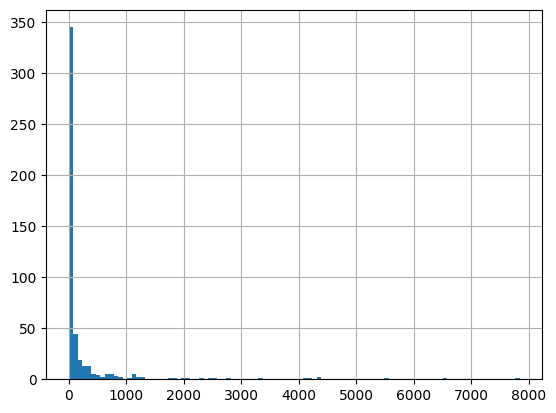

In [85]:
slide_enriched_tfs_scores['Max_Score'].hist(bins=100)
slide_enriched_tfs_scores['Max_Score'].describe()

In [87]:
sum(slide_enriched_tfs_scores['Max_Score']>100)

124